In [6]:
# TensorFlow
import tensorflow as tf

# TensorFlow Datsets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper Libraries
import numpy as np
import matplotlib.pyplot as plt
import pathlib

from os import getcwd

print('\u2022 Using TensorFlow Version:', tf.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.3.0-rc0
• GPU Device Not Found. Running on CPU


In [14]:
filePath = f"{getcwd()}/../tmp2/"
(train_examples, validation_examples, test_examples), info = tfds.load('fashion_mnist', with_info=True, as_supervised=True,
                                                             split=['train[80%:]', 'train[80%:90%]', 'train[90%:]'], data_dir=filePath)


num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [16]:
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [17]:
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [18]:
IMG_SIZE = 28

In [19]:
def format_example(image, label):
    # Cast image to float32
    image = tf.cast(image, tf.float32)
        
    # Normalize the image in the range [0, 1]
    image = image / 255.0
    
    label = tf.one_hot(label, num_classes)
    
    return image, label

In [20]:
BATCH_SIZE = 256

In [21]:
train_batches = train_examples.cache().shuffle(num_examples//4).batch(BATCH_SIZE).map(format_example).prefetch(1)
validation_batches = validation_examples.cache().batch(BATCH_SIZE).map(format_example)
test_batches = test_examples.map(format_example).batch(1)

In [24]:
batch_sample = next(iter(train_batches))

In [22]:
def show_batch(x,y,shape = None):
    """
    input: 
        x(Tensor[num_images, rows, columns]): images tensor
        y(array): labels
        shape(tuple): (rows,col) 
    output:
        grid of smaple images
    """

    if not shape:
        shape = (int(x.shape[0]**0.5), int(x.shape[0]**0.5))

    fig, axs = plt.subplots(nrows= shape[0], ncols=shape[1], figsize = (12,8))
    index = 0
    for row in axs:
        for ax in row:
            ax.imshow(tf.squeeze(x[index]).numpy())
            ax.set_xlabel(class_names[y[index].numpy().argmax()])
            index+=1

    # plt.subplots_adjust(wspace = 0.2, hspace = 0.5) 
    fig.tight_layout()
    plt.show()

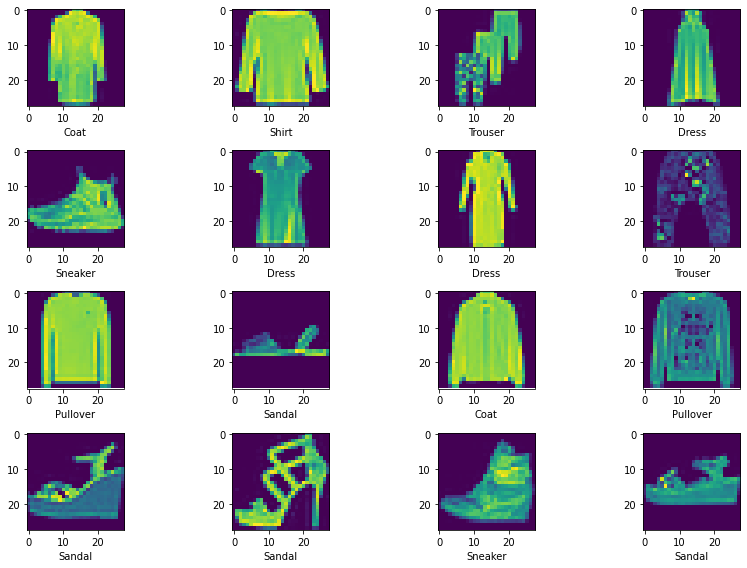

In [25]:
show_batch(batch_sample[0],batch_sample[1], (4,4))

In [26]:
model = tf.keras.Sequential([
# Set the input shape to (28, 28, 1), kernel size=3, filters=16 and use ReLU activation,
tf.keras.layers.Conv2D(input_shape = (28,28,1), kernel_size=3, filters=16,activation = "relu"),
      
tf.keras.layers.MaxPooling2D(),
      
# Set the number of filters to 32, kernel size to 3 and use ReLU activation 
tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
      
# Flatten the output layer to 1 dimension
tf.keras.layers.Flatten(),
      
# Add a fully connected layer with 64 hidden units and ReLU activation
tf.keras.layers.Dense(units=64, activation="relu"),
      
# Attach a final softmax classification head
tf.keras.layers.Dense(units = num_classes, activation="softmax")])

# Set the appropriate loss function and use accuracy as your metric
model.compile(optimizer='adam',
              loss= tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'] )

In [27]:
history = model.fit(train_batches, epochs=10, validation_data=validation_batches)

Epoch 1/10
47/47 [==============================] - 3s 56ms/step - loss: 0.9967 - accuracy: 0.6565 - val_loss: 0.6690 - val_accuracy: 0.7535
Epoch 2/10
47/47 [==============================] - 1s 29ms/step - loss: 0.5433 - accuracy: 0.8019 - val_loss: 0.4628 - val_accuracy: 0.8373
Epoch 3/10
47/47 [==============================] - 1s 27ms/step - loss: 0.4574 - accuracy: 0.8388 - val_loss: 0.4267 - val_accuracy: 0.8490
Epoch 4/10
47/47 [==============================] - 1s 26ms/step - loss: 0.4310 - accuracy: 0.8457 - val_loss: 0.4077 - val_accuracy: 0.8590
Epoch 5/10
47/47 [==============================] - 1s 28ms/step - loss: 0.4054 - accuracy: 0.8542 - val_loss: 0.3851 - val_accuracy: 0.8660
Epoch 6/10
47/47 [==============================] - 1s 28ms/step - loss: 0.3761 - accuracy: 0.8667 - val_loss: 0.3515 - val_accuracy: 0.8762
Epoch 7/10
47/47 [==============================] - 1s 25ms/step - loss: 0.3558 - accuracy: 0.8727 - val_loss: 0.3377 - val_accuracy: 0.8812
Epoch 8/10
47

In [28]:
export_dir = 'saved_model/1'

# YOUR CODE HERE
tf.saved_model.save(model, export_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2021-12-13 16:03:57.953043: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: saved_model/1/assets


INFO:tensorflow:Assets written to: saved_model/1/assets


In [29]:
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [30]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

2021-12-13 16:04:18.824599: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2021-12-13 16:04:18.825010: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2021-12-13 16:04:18.834081: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:816] Optimization results for grappler item: graph_to_optimize
2021-12-13 16:04:18.834109: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:818]   function_optimizer: Graph size after: 45 nodes (34), 44 edges (33), time = 1.15ms.
2021-12-13 16:04:18.834112: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:818]   function_optimizer: function_optimizer did nothing. time = 0.02ms.
2021-12-13 16:04:18.918526: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:313] Ignored output_format.
2021-12-13 16:04:18.918575: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored drop_control_dependency.
2021-12-13 16

In [31]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

259664

In [32]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [33]:
predictions = []
test_labels = []
test_images = []

for img, label in test_batches.take(50):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label[0])
    test_images.append(np.array(img))

2021-12-13 16:04:38.755228: W tensorflow/core/kernels/data/cache_dataset_ops.cc:798] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [34]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
#     print(predicted_label)
#     print(true_label.numpy().argmax())
    if predicted_label == true_label.numpy().argmax():
        color = 'green'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label.numpy().argmax()]),
                                         color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks(list(range(10)))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array[0], color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array[0])
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label.numpy().argmax()].set_color('blue')

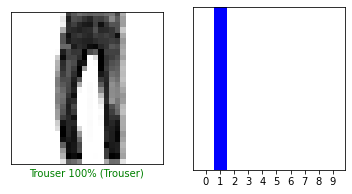

In [35]:
index = 49 

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(index, predictions, test_labels)
plt.show()

In [36]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [37]:
def representative_data_gen():
    for input_value, _ in test_batches.take(100):
        yield [input_value]


converter.representative_dataset = representative_data_gen